### Importing libraries

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Hyperparameters Set 

In [2]:
# Hyperparams
learning_rate = 0.0005
EPOCHS=15
MOMENTUM = 0.9
WEIGHT_DECAY = 1e-4

In [3]:
root_dir = 'D:/Confidential Reports/Deep learning class/assignment/round3'

### Downloading Dataset 

In [4]:
#automatic download
cifar_trainset = datasets.CIFAR10(root= root_dir, train=True, download=True, transform=transforms.ToTensor())



Extracting D:/Confidential Reports/Deep learning class/assignment/round3\cifar-10-python.tar.gz to D:/Confidential Reports/Deep learning class/assignment/round3


In [40]:
cifar_trainset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: D:/Confidential Reports/Deep learning class/assignment/round3
    Split: Train
    StandardTransform
Transform: ToTensor()

Label : truck


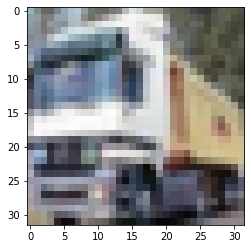

In [47]:
def display_img(img,label):
    print(f"Label : {cifar_trainset.classes[label]}")
    plt.imshow(img.permute(1,2,0))

#display the first image in the dataset
display_img(*cifar_trainset[1])

### CIFAR 10 Classes 

In [46]:
print("Follwing classes are there : \n",cifar_trainset.classes)

Follwing classes are there : 
 ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


###  Calculating Standard mean and deviation 

In [5]:
# Calculating Standard mean and deviation

imgs = [item[0] for item in cifar_trainset] # item[0] and item[1] are image and its label
imgs = torch.stack(imgs, dim=0).numpy()

# calculate mean over each channel (r,g,b)
mean_r = imgs[:,0,:,:].mean()
mean_g = imgs[:,1,:,:].mean()
mean_b = imgs[:,2,:,:].mean()
print(mean_r,mean_g,mean_b)

# calculate std over each channel (r,g,b)
std_r = imgs[:,0,:,:].std()
std_g = imgs[:,1,:,:].std()
std_b = imgs[:,2,:,:].std()
print(std_r,std_g,std_b)

0.49139968 0.48215827 0.44653124
0.24703233 0.24348505 0.26158768


In [6]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda:1')
    else:
        return torch.device('cpu')
DEVICE = get_default_device()

D:\Anaconda\lib\site-packages\torch\cuda\__init__.py:82: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  C:\cb\pytorch_1000000000000\work\c10\cuda\CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


### Data Augmentation 

In [8]:
normMean = [mean_r, mean_g, mean_b]
normStd = [std_r, std_g, std_b]
normTransform = transforms.Normalize(normMean, normStd)

trainTransform = transforms.Compose([
        transforms.Resize(256),
        transforms.RandomHorizontalFlip(10),
        transforms.RandomCrop(224, padding=16),
        transforms.ToTensor(),
        normTransform
    ])
testTransform = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        normTransform
    ])

In [9]:
train_dataset = datasets.CIFAR10(root= root_dir, train=True, download=True, transform=trainTransform)
test_dataset = datasets.CIFAR10(root= root_dir, train=False, download=True, transform=testTransform)

train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True)

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


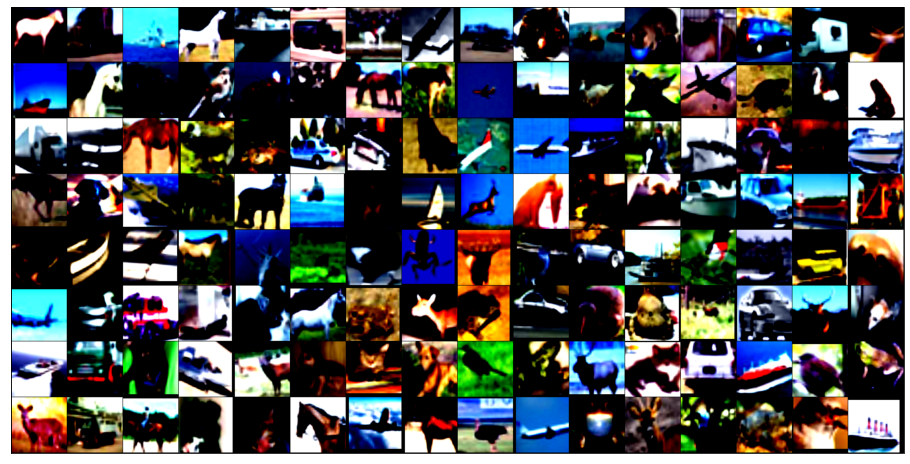

In [58]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break
        
show_batch(train_loader)

### Traing Size

In [43]:
train_dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: D:/Confidential Reports/Deep learning class/assignment/round3
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=10)
               RandomCrop(size=(224, 224), padding=16)
               ToTensor()
               Normalize(mean=[0.49139968, 0.48215827, 0.44653124], std=[0.24703233, 0.24348505, 0.26158768])
           )

### Testing Size

In [44]:
test_dataset

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: D:/Confidential Reports/Deep learning class/assignment/round3
    Split: Test
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.49139968, 0.48215827, 0.44653124], std=[0.24703233, 0.24348505, 0.26158768])
           )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


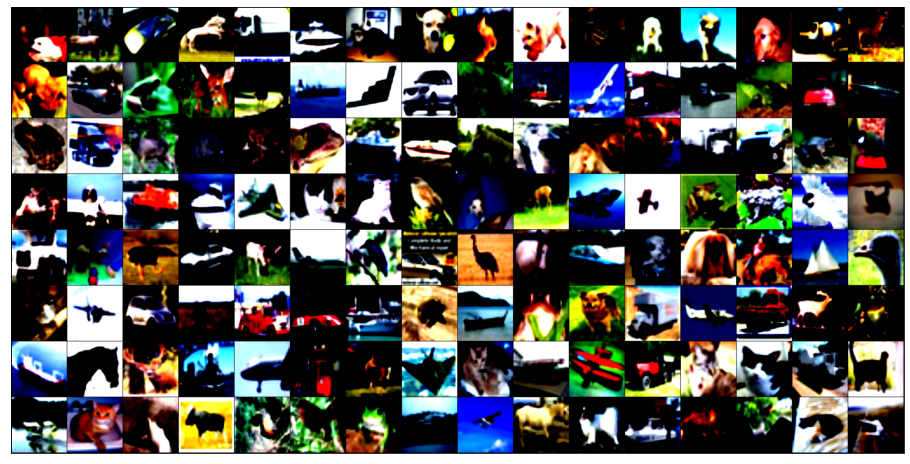

In [45]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break
        
show_batch(test_loader)

### ResNet50 model with added layers to improve learning

In [10]:
model = torchvision.models.resnet50(pretrained=True)
num_fltrs = model.fc.in_features
model.fc = nn.Sequential(
            nn.Linear(num_fltrs , 512),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),
            nn.GELU(),
            nn.Linear(512 , 256),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),
            nn.GELU(),
            nn.Linear(256 , 10),
            nn.Softmax(dim=1))

model = model.to(DEVICE)

### Loss and Optimizer

In [13]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), learning_rate,
                            momentum=MOMENTUM,
                            weight_decay=WEIGHT_DECAY, nesterov=True)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0005, max_lr=0.001)

### Trainning and Testing

In [15]:
def trainEpoch(device, model, loader, optimizer, criterion):
    grad_clip = 0.1
    loop = tqdm(loader)
    model.train()

    losses = []
    correct = 0
    total = 0
    for batch_id, (images, labels) in enumerate(loop):
        images, labels = images.to(device), labels.to(device)
        model = model.to(device)
        outputs = model(images)

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted==labels).sum().item()

        loss = criterion(outputs, labels)
        losses.append(loss.item())


        optimizer.zero_grad()
        loss.backward()
        if grad_clip: 
            nn.utils.clip_grad_value_(model.parameters(), grad_clip)
        
        optimizer.step()
        loop.set_postfix(train_loss=loss.item(), train_accuracy=(100*correct/total))

    return np.mean(losses), 100*correct/total


def testEpoch(device, model, loader, criterion):
    
    model.eval()
    with torch.no_grad():
        losses = []
        correct = 0
        total = 0
        loop = tqdm(loader)
        for batch_id, (images, labels) in enumerate(loop):
            images, labels = images.to(device), labels.to(device)
            model = model.to(device)
        
            outputs = model(images)

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted==labels).sum().item()

            loss = criterion(outputs, labels)
            losses.append(loss.item())

            loop.set_postfix(test_loss=loss.item(), test_accuracy=(100*correct/total))

        return np.mean(losses), 100*correct/total

### Training the model and saving the latest best

In [16]:
last_best = 0
train_losses = []
train_acc = []
test_losses = []
test_acc = []
for epoch in range (EPOCHS):
    
    train_loss, train_accuracy = trainEpoch(DEVICE, model, train_loader, optimizer, criterion)
    test_loss, test_accuracy = testEpoch(DEVICE, model, test_loader, criterion)

    train_losses.append(train_loss)
    train_acc.append(train_accuracy)
    test_losses.append(test_loss)
    test_acc.append(test_accuracy)

    scheduler.step()

    if last_best <= test_accuracy:
        torch.save(model.state_dict(), 'resnet_50_pretrained_baseline.pt')
        print("Saving new Best Model!")
        last_best = test_accuracy

    print("Train losses: {0:.3f},   Train acc: {1:.3f} ".format(train_losses[-1], train_acc[-1]))
    print("Test losses: {0:.3f},   Test acc: {1:.3f} ".format(test_losses[-1], test_acc[-1]))

dict = {'train_loss': train_losses, 'train_accuracy': train_acc, 'test_loss': test_losses, 'test_accuracy': test_acc}
df = pd.DataFrame(dict)
df.to_csv('malik1loss_and_acc_resnet.csv')

  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Saving new Best Model!
Train losses: 2.240,   Train acc: 28.382 
Test losses: 2.090,   Test acc: 54.560 


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Saving new Best Model!
Train losses: 1.971,   Train acc: 60.376 
Test losses: 1.833,   Test acc: 71.010 


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Saving new Best Model!
Train losses: 1.792,   Train acc: 76.678 
Test losses: 1.685,   Test acc: 86.830 


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Saving new Best Model!
Train losses: 1.659,   Train acc: 88.374 
Test losses: 1.598,   Test acc: 91.010 


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Saving new Best Model!
Train losses: 1.600,   Train acc: 90.972 
Test losses: 1.564,   Test acc: 92.600 


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Saving new Best Model!
Train losses: 1.573,   Train acc: 92.280 
Test losses: 1.551,   Test acc: 93.330 


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Saving new Best Model!
Train losses: 1.557,   Train acc: 93.198 
Test losses: 1.539,   Test acc: 93.850 


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Saving new Best Model!
Train losses: 1.546,   Train acc: 93.702 
Test losses: 1.534,   Test acc: 94.330 


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Saving new Best Model!
Train losses: 1.537,   Train acc: 94.350 
Test losses: 1.530,   Test acc: 94.530 


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Saving new Best Model!
Train losses: 1.529,   Train acc: 94.882 
Test losses: 1.526,   Test acc: 94.640 


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Saving new Best Model!
Train losses: 1.524,   Train acc: 95.214 
Test losses: 1.521,   Test acc: 95.010 


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Saving new Best Model!
Train losses: 1.518,   Train acc: 95.682 
Test losses: 1.520,   Test acc: 95.020 


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Train losses: 1.514,   Train acc: 96.008 
Test losses: 1.518,   Test acc: 94.940 


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Saving new Best Model!
Train losses: 1.511,   Train acc: 96.196 
Test losses: 1.515,   Test acc: 95.190 


100%|██████████████████████████████████████████████| 79/79 [18:59<00:00, 14.42s/it, test_accuracy=95.3, test_loss=1.53]


Saving new Best Model!
Train losses: 1.508,   Train acc: 96.442 
Test losses: 1.515,   Test acc: 95.330 


In [17]:
df

,train_loss,train_accuracy,test_loss,test_accuracy
0,2.239906,28.382,2.090321,54.56
1,1.971422,60.376,1.833009,71.01
2,1.792385,76.678,1.684914,86.83
3,1.659494,88.374,1.597691,91.01
4,1.600455,90.972,1.564074,92.60
5,1.573371,92.280,1.550619,93.33
6,1.556534,93.198,1.538628,93.85
7,1.545827,93.702,1.534015,94.33
8,1.536555,94.350,1.529912,94.53
9,1.529476,94.882,1.526053,94.64


In [19]:
df.to_csv('Malik_loss_and_acc_resnet.csv')

### Further we trained the model to improve the accuracy

In [21]:
for epoch in range (2):
    
    train_loss, train_accuracy = trainEpoch(DEVICE, model, train_loader, optimizer, criterion)
    test_loss, test_accuracy = testEpoch(DEVICE, model, test_loader, criterion)

    train_losses.append(train_loss)
    train_acc.append(train_accuracy)
    test_losses.append(test_loss)
    test_acc.append(test_accuracy)

    scheduler.step()

    if last_best <= test_accuracy:
        torch.save(model.state_dict(), 'resnet_50_pretrained_baseline.pt')
        print("Saving new Best Model!")
        last_best = test_accuracy

    print("Train losses: {0:.3f},   Train acc: {1:.3f} ".format(train_losses[-1], train_acc[-1]))
    print("Test losses: {0:.3f},   Test acc: {1:.3f} ".format(test_losses[-1], test_acc[-1]))

dict = {'train_loss': train_losses, 'train_accuracy': train_acc, 'test_loss': test_losses, 'test_accuracy': test_acc}
df = pd.DataFrame(dict)
df.to_csv('loss_and_acc_resnet.csv')

  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Train losses: 1.504,   Train acc: 96.690 
Test losses: 1.515,   Test acc: 95.210 


100%|██████████████████████████████████████████████| 79/79 [21:14<00:00, 16.13s/it, test_accuracy=95.3, test_loss=1.57]

Train losses: 1.502,   Train acc: 96.844 
Test losses: 1.515,   Test acc: 95.270 


In [22]:
df


,train_loss,train_accuracy,test_loss,test_accuracy
0,2.239906,28.382,2.090321,54.56
1,1.971422,60.376,1.833009,71.01
2,1.792385,76.678,1.684914,86.83
3,1.659494,88.374,1.597691,91.01
4,1.600455,90.972,1.564074,92.60
5,1.573371,92.280,1.550619,93.33
6,1.556534,93.198,1.538628,93.85
7,1.545827,93.702,1.534015,94.33
8,1.536555,94.350,1.529912,94.53
9,1.529476,94.882,1.526053,94.64


In [23]:
for epoch in range (2):
    
    train_loss, train_accuracy = trainEpoch(DEVICE, model, train_loader, optimizer, criterion)
    test_loss, test_accuracy = testEpoch(DEVICE, model, test_loader, criterion)

    train_losses.append(train_loss)
    train_acc.append(train_accuracy)
    test_losses.append(test_loss)
    test_acc.append(test_accuracy)

    scheduler.step()

    if last_best <= test_accuracy:
        torch.save(model.state_dict(), 'resnet_50_pretrained_baseline.pt')
        print("Saving new Best Model!")
        last_best = test_accuracy

    print("Train losses: {0:.3f},   Train acc: {1:.3f} ".format(train_losses[-1], train_acc[-1]))
    print("Test losses: {0:.3f},   Test acc: {1:.3f} ".format(test_losses[-1], test_acc[-1]))

dict = {'train_loss': train_losses, 'train_accuracy': train_acc, 'test_loss': test_losses, 'test_accuracy': test_acc}
df = pd.DataFrame(dict)
df.to_csv('loss_and_acc_resnet.csv')

  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Train losses: 1.500,   Train acc: 97.054 
Test losses: 1.514,   Test acc: 95.260 


100%|██████████████████████████████████████████████| 79/79 [19:43<00:00, 14.98s/it, test_accuracy=95.5, test_loss=1.46]


Saving new Best Model!
Train losses: 1.497,   Train acc: 97.244 
Test losses: 1.510,   Test acc: 95.480 


In [24]:
df

,train_loss,train_accuracy,test_loss,test_accuracy
0,2.239906,28.382,2.090321,54.56
1,1.971422,60.376,1.833009,71.01
2,1.792385,76.678,1.684914,86.83
3,1.659494,88.374,1.597691,91.01
4,1.600455,90.972,1.564074,92.60
5,1.573371,92.280,1.550619,93.33
6,1.556534,93.198,1.538628,93.85
7,1.545827,93.702,1.534015,94.33
8,1.536555,94.350,1.529912,94.53
9,1.529476,94.882,1.526053,94.64


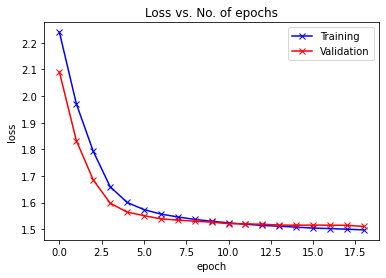

In [28]:
def plot_losses():
    """ Plot the history of losses"""
    plt.plot(train_losses, '-bx')
    plt.plot( test_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
    

plot_losses()

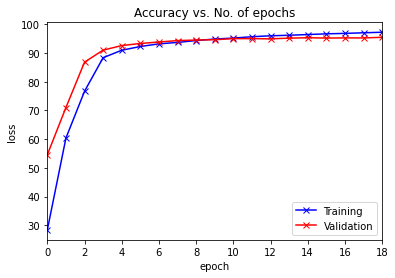

In [33]:
def plot_accuracies():
    """ Plot the history of losses"""
    plt.plot(train_acc, '-bx')
    plt.plot(test_acc, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Accuracy vs. No. of epochs');
    plt.xlim([0, 18])
plot_accuracies()


In [66]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [72]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


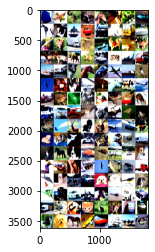

GroundTruth:  truck plane deer  deer 


In [73]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [78]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}


# again no gradients needed
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 96.8 %
Accuracy for class: car   is 98.1 %
Accuracy for class: bird  is 93.9 %
Accuracy for class: cat   is 88.5 %
Accuracy for class: deer  is 96.2 %
Accuracy for class: dog   is 92.7 %
Accuracy for class: frog  is 98.6 %
Accuracy for class: horse is 97.0 %
Accuracy for class: ship  is 96.5 %
Accuracy for class: truck is 96.5 %


### For further improve the accuracy by training the model for more number of epochs

In [127]:
for epoch in range (25):
    
    train_loss, train_accuracy = trainEpoch(DEVICE, model, train_loader, optimizer, criterion)
    test_loss, test_accuracy = testEpoch(DEVICE, model, test_loader, criterion)

    train_losses.append(train_loss)
    train_acc.append(train_accuracy)
    test_losses.append(test_loss)
    test_acc.append(test_accuracy)

    scheduler.step()

    if last_best <= test_accuracy:
        torch.save(model.state_dict(), 'resnet_50_pretrained_baseline.pt')
        print("Saving new Best Model!")
        last_best = test_accuracy

    print("Train losses: {0:.3f},   Train acc: {1:.3f} ".format(train_losses[-1], train_acc[-1]))
    print("Test losses: {0:.3f},   Test acc: {1:.3f} ".format(test_losses[-1], test_acc[-1]))

dict = {'train_loss': train_losses, 'train_accuracy': train_acc, 'test_loss': test_losses, 'test_accuracy': test_acc}
df = pd.DataFrame(dict)
df.to_csv('malik1_for epoch in range (25):
    
    train_loss, train_accuracy = trainEpoch(DEVICE, model, train_loader, optimizer, criterion)
    test_loss, test_accuracy = testEpoch(DEVICE, model, test_loader, criterion)

    train_losses.append(train_loss)
    train_acc.append(train_accuracy)
    test_losses.append(test_loss)
    test_acc.append(test_accuracy)

    scheduler.step()

    if last_best <= test_accuracy:
        torch.save(model.state_dict(), 'resnet_50_pretrained_baseline.pt')
        print("Saving new Best Model!")
        last_best = test_accuracy

    print("Train losses: {0:.3f},   Train acc: {1:.3f} ".format(train_losses[-1], train_acc[-1]))
    print("Test losses: {0:.3f},   Test acc: {1:.3f} ".format(test_losses[-1], test_acc[-1]))

dict = {'train_loss': train_losses, 'train_accuracy': train_acc, 'test_loss': test_losses, 'test_accuracy': test_acc}
df = pd.DataFrame(dict)
df.to_csv('malik1_loss_and_acc_resnet.csv')loss_and_acc_resnet.csv')

In [135]:
df

,Unnamed: 0,train_loss,train_accuracy,test_loss,test_accuracy
0,0,2.239906,28.3820,2.090321,54.560
1,1,1.971422,60.3760,1.833009,71.010
2,2,1.792385,76.6780,1.684914,86.830
3,3,1.659494,88.3740,1.597691,91.010
4,4,1.600455,90.9720,1.564074,92.600
5,5,1.573371,92.2800,1.550619,93.330
6,6,1.556534,93.1980,1.538628,93.850
7,7,1.545827,93.7020,1.534015,94.330
8,8,1.536555,94.3500,1.529912,94.530
9,9,1.529476,94.8820,1.526053,94.640


In [136]:
train_loss = df.iloc[:,1].values
train_accuracy = df.iloc[:,2].values
test_loss = df.iloc[:,3].values
test_accuracy = df.iloc[:,4].values


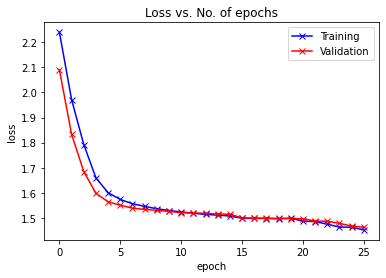

In [137]:
def plot_losses():
    """ Plot the history of losses"""
    plt.plot(train_loss, '-bx')
    plt.plot( test_loss, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
    

plot_losses()

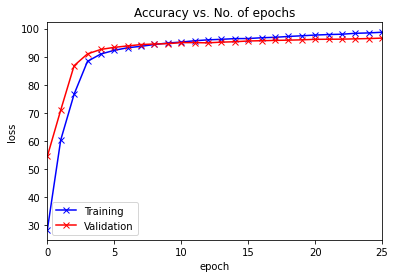

In [138]:
def plot_accuracies():
    """ Plot the history of losses"""
    plt.plot(train_accuracy, '-bx')
    plt.plot(test_accuracy, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Accuracy vs. No. of epochs');
    plt.xlim([0, 25])
plot_accuracies()

In [132]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}


# again no gradients needed
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 98.8 %
Accuracy for class: car   is 98.1 %
Accuracy for class: bird  is 95.9 %
Accuracy for class: cat   is 94.5 %
Accuracy for class: deer  is 96.2 %
Accuracy for class: dog   is 94.7 %
Accuracy for class: frog  is 98.6 %
Accuracy for class: horse is 97.0 %
Accuracy for class: ship  is 96.5 %
Accuracy for class: truck is 96.5 %
